### SSVQE for H2 molecule
Exchange packages Qiskit to QLM to Cirq

In this notebook we use 3 quantum programming languages, Qiskit, QLM and Cirq to calculate the ground state energy and the first excited state energy of $H_{2}$ molecule.

We also make use of the myQLM library to exchange between the programming languages packages.

We start with qiskit then qlm and finally cirq.

### Outline
<ol>
    <li>Energy calculation using Qiskit</li>
    <li>Energy calculation using QLM</li>
    <li>Energy calculation using Cirq</li>
    <li>Conclusion</li>
    <li>References</li>
</ol>

### Energy calculation using qiskit
<hr>

In [1]:
from qiskit import *
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info.operators import Operator, Pauli

import numpy as np
from qiskit.opflow import I, X, Y, Z
from qiskit import Aer

C:\Users\husse\AppData\Local\Temp\ipykernel_14232\3267642257.py:6: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, X, Y, Z


The following cell is to get rid of warnings like deprecated qiskit versions, for example.

In [2]:
import warnings
warnings.filterwarnings('ignore')

H2 hamiltonian

In [3]:
H2_op = (-0.24274280046588792)*Operator(Pauli('IIZI')) + (-0.24274280046588792)*Operator(Pauli('IIIZ')) + (-0.04207898539364302)*Operator(Pauli('IIII')) + (0.17771287502681438)*Operator(Pauli('ZIII')) + (0.1777128750268144)*Operator(Pauli('IZII')) + (0.12293305045316086)*Operator(Pauli('ZIZI')) + (0.12293305045316086)*Operator(Pauli('IZIZ')) + (0.16768319431887935)*Operator(Pauli('ZIIZ')) + (0.16768319431887935)*Operator(Pauli('IZZI')) + (0.1705973836507714)*Operator(Pauli('ZZII')) + (0.1762764072240811)*Operator(Pauli('IIZZ')) + (-0.044750143865718496)*Operator(Pauli('YYXX')) + (-0.044750143865718496)*Operator(Pauli('XXYY')) + (0.044750143865718496)*Operator(Pauli('YXXY')) + (0.044750143865718496)*Operator(Pauli('XYYX'))

A function that returns the expectation value of a circuit on an observable for given parameters.

In [4]:
def expectation(circuit, params, H):
  circ = circuit.assign_parameters(params)
  simulator = Aer.get_backend('statevector_simulator')
  result = execute(circ, simulator).result().get_statevector()
  expectation_value = result.expectation_value(H).real
  return expectation_value

We define the ansatz as this one given in the following research paper.
https://ar5iv.labs.arxiv.org/html/1810.09434

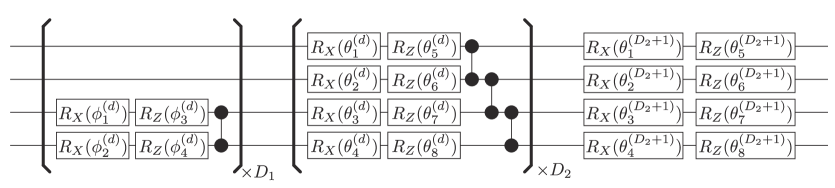

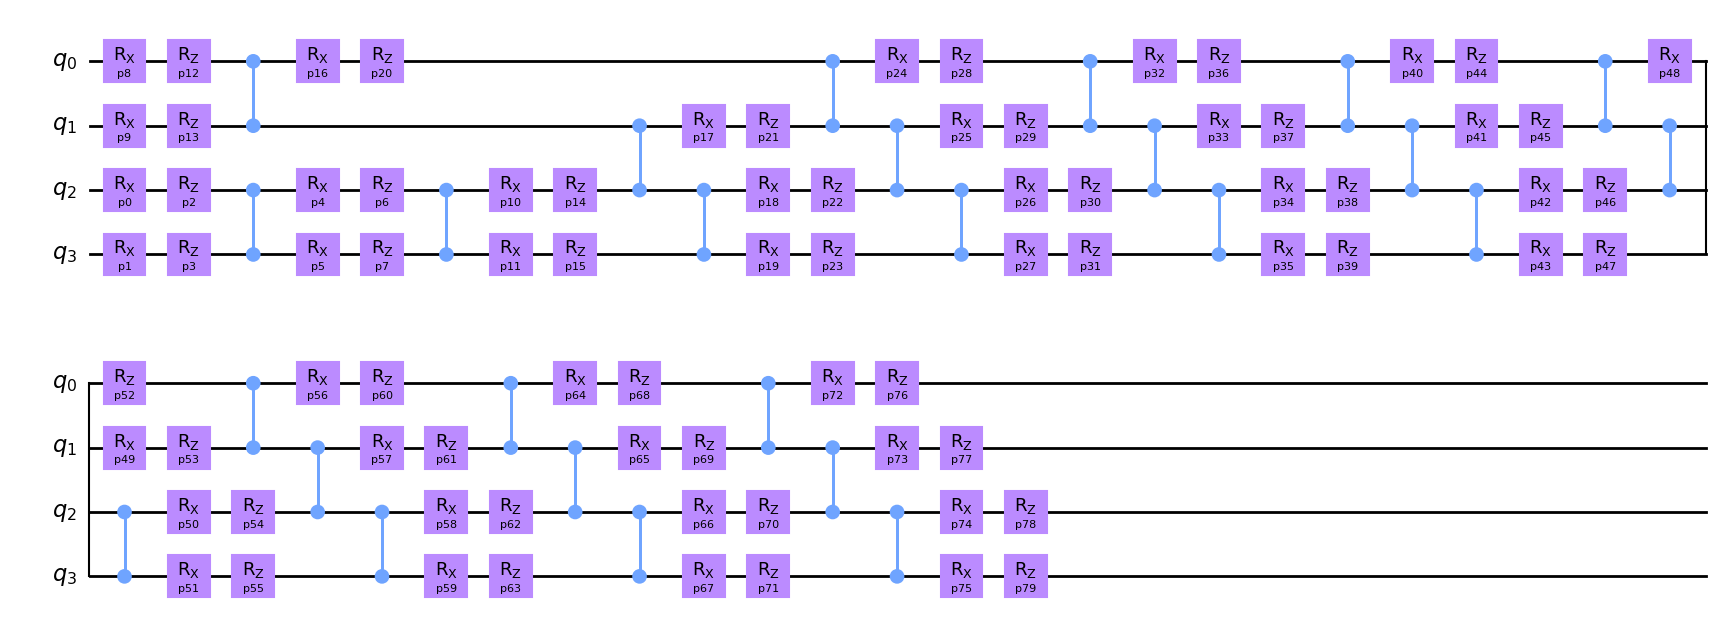

In [5]:
qc = QuantumCircuit(4)

D1 = 2
D2 = 8
num_p = 4*D1 + 8*D2 + 8

prs = [Parameter('p'+str(i)) for i in range(num_p)]

k = 0
for i in range(D1):
    qc.rx(prs[k], 2)
    k = k+1
    qc.rx(prs[k], 3)
    k = k+1

    qc.rz(prs[k], 2)
    k = k+1
    qc.rz(prs[k], 3)
    k = k+1

    qc.cz(2, 3)

for i in range(D2):
    qc.rx(prs[k], 0)
    k = k+1
    qc.rx(prs[k], 1)
    k = k+1
    qc.rx(prs[k], 2)
    k = k+1
    qc.rx(prs[k], 3)
    k = k+1

    qc.rz(prs[k], 0)
    k = k+1
    qc.rz(prs[k], 1)
    k = k+1
    qc.rz(prs[k], 2)
    k = k+1
    qc.rz(prs[k], 3)
    k = k+1

    

    qc.cz(0, 1)
    qc.cz(1, 2)
    qc.cz(2, 3)

qc.rx(prs[k], 0)
k = k+1
qc.rx(prs[k], 1)
k = k+1
qc.rx(prs[k], 2)
k = k+1
qc.rx(prs[k], 3)
k = k+1

qc.rz(prs[k], 0)
k = k+1
qc.rz(prs[k], 1)
k = k+1
qc.rz(prs[k], 2)
k = k+1
qc.rz(prs[k], 3)
k = k+1

qc.draw('mpl')

By adding an X gate to first qubit, the input state is the first excited state |0001> instead of the ground state |000>.

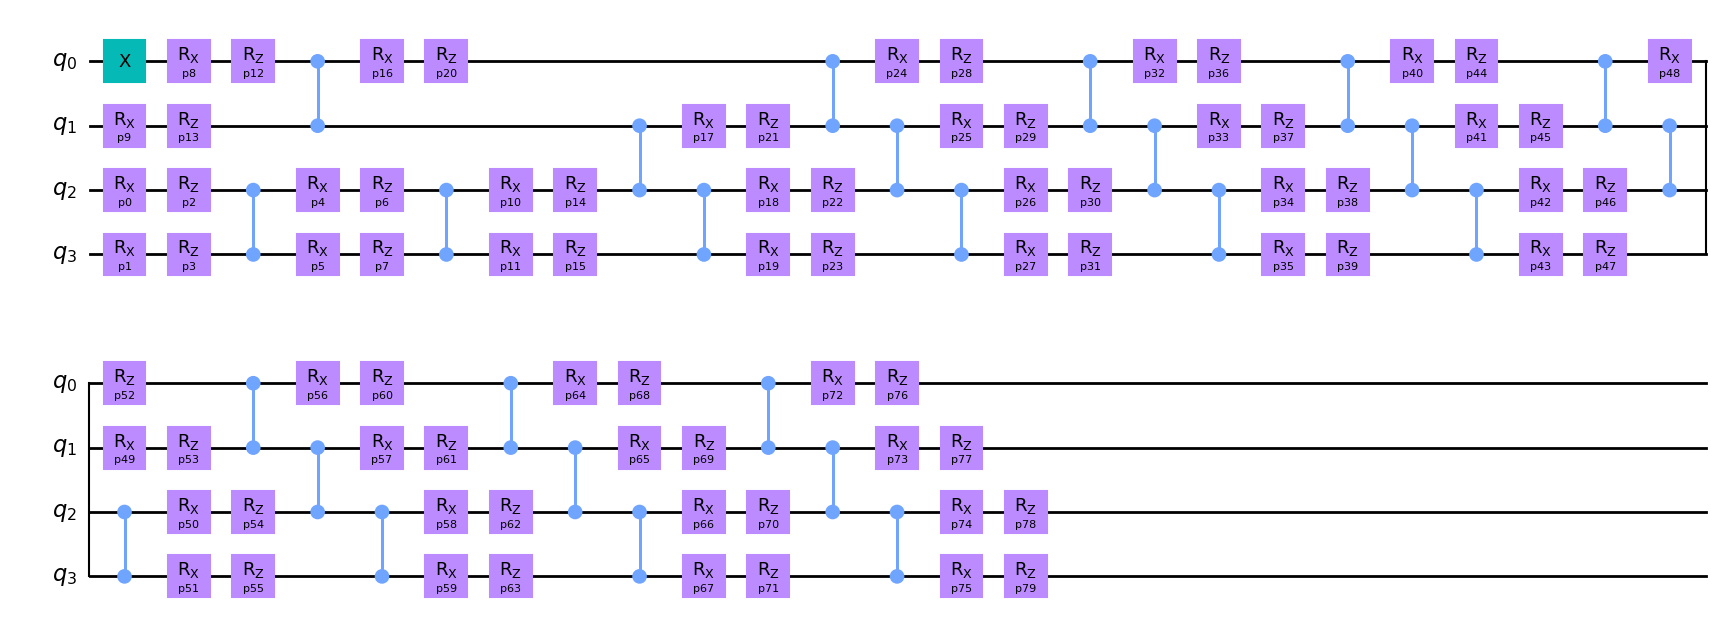

In [6]:
qc2 = QuantumCircuit(4)
qc2.x(0)
qc2 = qc2.compose(qc)
qc2.draw('mpl')

We define 2 weights to use with SSVQE. By other words we are using Weighted-SSVQE.

In [7]:
import numpy as np

w = np.arange(4, 2, -1)
w

array([4, 3])

The following list contains 2 circuits, first with input |0000> and the second with input |0001>.

In [8]:
qcs = [qc, qc2]

We calculate the gradients using the parameter shift rule for pauli operators. Calculating the gradients is used to update the parameters of the circuit.
$\nabla_{\theta}f(x; \theta) = \tfrac{1}{2}\left[ f(x; \theta + \tfrac{\pi}{2}) - f(x; \theta - \tfrac{\pi}{2}) \right]$.
Where f(x) is the expectation value of the circuit on the observable for specific parameters.

In [9]:
def gradient(qcs, H, w, num_qubits, parameters):
    gradients = np.zeros((len(parameters), ))
    cost = 0
    parameters = list(parameters)
    for i in range(num_qubits-2):
        for j in range(len(parameters)):
            parameters1 = parameters[:]
            parameters1[j] += +np.pi/2
            parameters2 = parameters[:]
            parameters2[j] += -np.pi/2
            term = w[i]*0.5*(expectation(qcs[i], parameters1, H) - expectation(qcs[i], parameters2, H))
            gradients[j] += term
        cost += w[i]*expectation(qcs[i], parameters, H)
    return gradients, cost

The following is the implementation of the Adam optimizer from scratch. It uses the previously calculated gradients to update the parameters at each iteration.

In [10]:
import math, random

def adam(qcs, n_iter, alpha, beta1, beta2, H, w, num_qubits, combined, eps=1e-8):
	# generate an initial point
	# Parameters
    mean = 0
    std_dev = 2*np.pi
    num_samples = len(list(qcs[0].parameters))
    score0 = 10

    # Generate samples
    x = np.array([float(random.gauss(mean, std_dev)) for _ in range(num_samples)], dtype=np.float32)
	# initialize first and second moments
    m = [0.0 for _ in range(x.shape[0])]
    v = [0.0 for _ in range(x.shape[0])]
	# run the gradient descent updates
    for t in range(n_iter):
		# calculate gradient g(t)
        qcs2 = qcs[:]
        g, score = gradient(qcs2, H, w, num_qubits, x)
		# build a solution one variable at a time
        for i in range(x.shape[0]):
			# m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
			# v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
			# mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
			# vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
			# x(t) = x(t-1) - alpha * mhat(t) / sqrt(vhat(t)) + eps
            x[i] = x[i] - alpha * mhat / (math.sqrt(vhat) + eps)
		# report progress
        print('>%d score = %.5f' % (t, score))
        combined.append((t, x, score))
    return [x, score]

We run now SSVQE to find the ground and excited states of $H_{2}$.

In [11]:
combined = []
# define the total iterations
max_n_iter = 35
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.9
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam(qcs = qcs, n_iter=max_n_iter, alpha=alpha, beta1=beta1, beta2=beta2, H=H2_op, w=w, num_qubits=4, combined=combined, eps=1e-8)
print('Done!')
print('f(%s) = %f' % (best, score))

>0 score = -0.57900
>1 score = -2.61790
>2 score = -3.55736
>3 score = -3.79986
>4 score = -4.24818
>5 score = -4.65041
>6 score = -5.03060
>7 score = -5.34312
>8 score = -5.55045
>9 score = -5.64703
>10 score = -5.66047
>11 score = -5.69970
>12 score = -5.72720
>13 score = -5.72518
>14 score = -5.73901
>15 score = -5.75617
>16 score = -5.78287
>17 score = -5.81452
>18 score = -5.83876
>19 score = -5.87365
>20 score = -5.88342
>21 score = -5.88059
>22 score = -5.89145
>23 score = -5.90046
>24 score = -5.90789
>25 score = -5.90623
>26 score = -5.90838
>27 score = -5.91679
>28 score = -5.92434
>29 score = -5.93414
>30 score = -5.93705
>31 score = -5.94006
>32 score = -5.94179
>33 score = -5.94554
>34 score = -5.95295
Done!
f([  2.3096974   11.839085    -2.0384529   -6.8996673   -1.0638465
   1.8359907    2.633047    -2.4436624   -0.02121193 -10.540049
   3.6983142   -8.776593     6.3583193   -7.4479675   -7.7138176
  -3.4174886  -10.789144    -9.444136    -8.351782     8.475474
   6.1292

Text(0.5, 1.0, 'Energy of ground and excited states for each iteration of Adam')

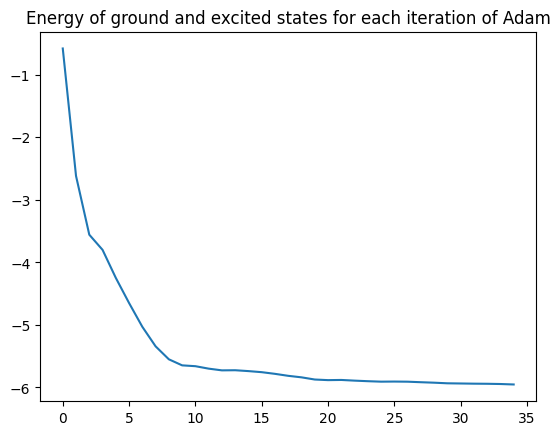

In [12]:
energies = [combined[i][2] for i in range(len(combined))]

import matplotlib.pyplot as plt
plt.plot(list(range(len(combined))), energies)
plt.title("Energy of ground and excited states for each iteration of Adam")

In [13]:
best=combined[-1][1]

In [14]:
print("The ground state energy of H2 is ", expectation(qcs[0], best, H2_op))

The ground state energy of H2 is  -1.1338174908008054


In [15]:
print("The excited state energy of H2 is ", expectation(qcs[1], best, H2_op))

The excited state energy of H2 is  -0.4734809757859316


### Energy calculation using QLM
<hr>

First we need to change the circuit from Qiskit to QLM

In [16]:
from qat.lang import *
from qat import *
from qat.interop.qiskit import qiskit_to_qlm

qlm_circuit = qiskit_to_qlm(qc)

In [17]:
qlm_circuit().display()

qcs now contains the 2 circuits defined previously in qiskit.

In [18]:
qcs = [qiskit_to_qlm(qc), qiskit_to_qlm(qc2)]

After successfully changing the circuit, we can now find the parameters present in it.

In [19]:
qlm_circuit.get_variables()

['p0',
 'p1',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16',
 'p17',
 'p18',
 'p19',
 'p2',
 'p20',
 'p21',
 'p22',
 'p23',
 'p24',
 'p25',
 'p26',
 'p27',
 'p28',
 'p29',
 'p3',
 'p30',
 'p31',
 'p32',
 'p33',
 'p34',
 'p35',
 'p36',
 'p37',
 'p38',
 'p39',
 'p4',
 'p40',
 'p41',
 'p42',
 'p43',
 'p44',
 'p45',
 'p46',
 'p47',
 'p48',
 'p49',
 'p5',
 'p50',
 'p51',
 'p52',
 'p53',
 'p54',
 'p55',
 'p56',
 'p57',
 'p58',
 'p59',
 'p6',
 'p60',
 'p61',
 'p62',
 'p63',
 'p64',
 'p65',
 'p66',
 'p67',
 'p68',
 'p69',
 'p7',
 'p70',
 'p71',
 'p72',
 'p73',
 'p74',
 'p75',
 'p76',
 'p77',
 'p78',
 'p79',
 'p8',
 'p9']

Now we build the hamiltonion for $H_{2}$ manually the same as the one in Qiskit, since myQLM library supports changing circuit between packages and not changing hamiltonian.

In [20]:
from qat.core import Observable, Term

my_observable = Observable(4, # A 4 qubits observable
                           pauli_terms=[
                               Term(-0.24274280046588792, 'IIZI', [0, 1, 2, 3]),
                               Term(-0.24274280046588792, 'IIIZ', [0, 1, 2, 3]),
                               Term(-0.04207898539364302, 'IIII', [0, 1, 2, 3]),
                               Term(0.17771287502681438, 'ZIII', [0, 1, 2, 3]),
                               Term(0.1777128750268144, 'IZII', [0, 1, 2, 3]),
                               Term(0.12293305045316086, 'ZIZI', [0, 1, 2, 3]),
                               Term(0.12293305045316086, 'IZIZ', [0, 1, 2, 3]),
                               Term(0.16768319431887935, 'ZIIZ', [0, 1, 2, 3]),
                               Term(0.16768319431887935, 'IZZI', [0, 1, 2, 3]),
                               Term(0.1705973836507714, 'ZZII', [0, 1, 2, 3]),
                               Term(0.1762764072240811, 'IIZZ', [0, 1, 2, 3]),
                               Term(-0.044750143865718496, 'YYXX', [0, 1, 2, 3]),
                               Term(-0.044750143865718496, 'XXYY', [0, 1, 2, 3]),
                               Term(0.044750143865718496, 'YXXY', [0, 1, 2, 3]),
                               Term(0.044750143865718496, 'XYYX', [0, 1, 2, 3])
                           ],
                           constant_coeff=0)
print(my_observable)

-0.04207898539364302 * I^4 +
-0.24274280046588792 * (Z|[2]) +
-0.24274280046588792 * (Z|[3]) +
0.17771287502681438 * (Z|[0]) +
0.1777128750268144 * (Z|[1]) +
0.12293305045316086 * (ZZ|[0, 2]) +
0.12293305045316086 * (ZZ|[1, 3]) +
0.16768319431887935 * (ZZ|[0, 3]) +
0.16768319431887935 * (ZZ|[1, 2]) +
0.1705973836507714 * (ZZ|[0, 1]) +
0.1762764072240811 * (ZZ|[2, 3]) +
-0.044750143865718496 * (YYXX|[0, 1, 2, 3]) +
-0.044750143865718496 * (XXYY|[0, 1, 2, 3]) +
0.044750143865718496 * (YXXY|[0, 1, 2, 3]) +
0.044750143865718496 * (XYYX|[0, 1, 2, 3])


We now define 2 functions the same as expectation() and gradient() functions in qiskit but we define them to work with qlm qpu instead of qiskit qpu.

In [21]:
import numpy as np
def expectation_qlm(crq, params, H):
    vs = [v for v in crq.get_variables()]
    variables = {vs[i]:params[i] for i in range(len(vs))}
    crq = crq.bind_variables(variables)
    result1 = np.matmul(crq.eval().statevector.transpose().conjugate(), H.to_matrix(sparse=False))
    return float(np.matmul(result1, crq.eval().statevector).real)

In [22]:
def gradient_qlm(qcs, H, w, num_qubits, parameters):
    gradients = np.zeros((len(parameters), ))
    cost = 0
    parameters = list(parameters)
    for i in range(num_qubits-2):
        for j in range(len(parameters)):
            parameters1 = parameters[:]
            parameters1[j] += +np.pi/2
            parameters2 = parameters[:]
            parameters2[j] += -np.pi/2
            term = w[i]*0.5*(expectation_qlm(qcs[i], parameters1, H) - expectation_qlm(qcs[i], parameters2, H))
            gradients[j] += term
        cost += w[i]*expectation_qlm(qcs[i], parameters, H)
    return gradients, cost

adam_qlm() function is the same as adam() previous function but it works for qlm instead of qiskit.

In [23]:
import math, random

def adam_qlm(qcs, n_iter, alpha, beta1, beta2, H, w, num_qubits, combined, eps=1e-8):
	# generate an initial point
	# Parameters
    mean = 0
    std_dev = 2*np.pi
    num_samples = len(list(qcs[0].get_variables()))
    score0 = 10

    # Generate samples
    x = np.array([float(random.gauss(mean, std_dev)) for _ in range(num_samples)], dtype=np.float32)
	# initialize first and second moments
    m = [0.0 for _ in range(x.shape[0])]
    v = [0.0 for _ in range(x.shape[0])]
	# run the gradient descent updates
    for t in range(n_iter):
		# calculate gradient g(t)
        qcs2 = qcs[:]
        g, score = gradient_qlm(qcs2, H, w, num_qubits, x)
		# build a solution one variable at a time
        for i in range(x.shape[0]):
			# m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
			# v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
			# mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
			# vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
			# x(t) = x(t-1) - alpha * mhat(t) / sqrt(vhat(t)) + eps
            x[i] = x[i] - alpha * mhat / (math.sqrt(vhat) + eps)
		# report progress
        print('>%d score = %.5f' % (t, score))
        combined.append((t, x, score))
    return [x, score]

We rerun adam and calculate the ground and first excited states of $H_{2}$.

In [24]:
combined = []
# define the total iterations
max_n_iter = 35
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.9
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam_qlm(qcs = qcs, n_iter=max_n_iter, alpha=alpha, beta1=beta1, beta2=beta2, H=my_observable, w=w, num_qubits=4, combined=combined, eps=1e-8)
print('Done!')
print('f(%s) = %f' % (best, score))

>0 score = -0.09207
>1 score = -2.25929
>2 score = -3.34113
>3 score = -3.98799
>4 score = -4.46023
>5 score = -4.80724
>6 score = -5.29258
>7 score = -5.38881
>8 score = -5.24920
>9 score = -5.30329
>10 score = -5.47407
>11 score = -5.60179
>12 score = -5.71392
>13 score = -5.78580
>14 score = -5.78207
>15 score = -5.77454
>16 score = -5.81895
>17 score = -5.87147
>18 score = -5.89291
>19 score = -5.90432
>20 score = -5.91745
>21 score = -5.91827
>22 score = -5.92618
>23 score = -5.96344
>24 score = -6.00558
>25 score = -6.02227
>26 score = -6.02443
>27 score = -6.02959
>28 score = -6.03647
>29 score = -6.04361
>30 score = -6.04749
>31 score = -6.05044
>32 score = -6.06175
>33 score = -6.07388
>34 score = -6.07873
Done!
f([ 11.0630665    8.2517185    2.0361736    0.12205955   3.690435
   2.7728956    4.438396    -2.2867055   -0.49361676   6.2408295
  -3.767638    -5.0361824    2.9320145   -3.0734553    6.762523
   5.7733903    3.7178981   -4.0027447    9.218395    -1.6702855
 -11.8304

Text(0.5, 1.0, 'Energy of ground and excited states for each iteration of Adam')

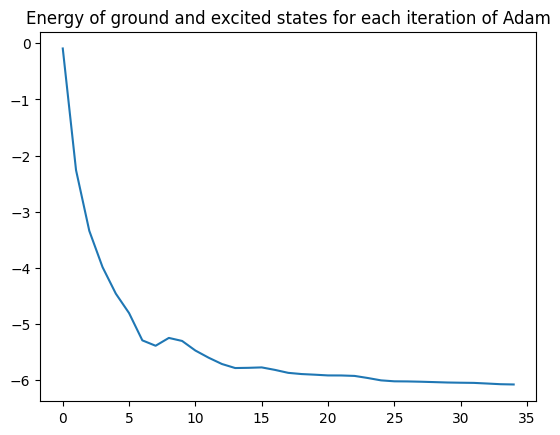

In [25]:
energies = [combined[i][2] for i in range(len(combined))]

import matplotlib.pyplot as plt
plt.plot(list(range(len(combined))), energies)
plt.title("Energy of ground and excited states for each iteration of Adam")

We now get the last parameters returned in the last iteration.

In [26]:
best = combined[-1][1]

In [27]:
print("The ground state energy of H2 is ", expectation_qlm(qcs[0], best, my_observable))

The ground state energy of H2 is  -1.1297655727084672


In [28]:
print("The excited state energy of H2 is ", expectation_qlm(qcs[1], best, my_observable))

The excited state energy of H2 is  -0.5207028646023496


Save the variables names for later use with cirq.

In [29]:
all_variables = qlm_circuit.get_variables()

### Energy calculation using circ
<hr>

First we need to change the circuit into type cirq instead of QLM type.

In [30]:
from qat.interop.cirq import qlm_to_cirq
qcs = [qlm_to_cirq(qiskit_to_qlm(qc)), qlm_to_cirq(qiskit_to_qlm(qc2))]

We now define 2 arrays for storing the energies and parameters.

In [31]:
import random
energies = []
random_params = []

Now we define the simulator in circ.

In [32]:
import cirq

simulator = cirq.Simulator()

Now we define the observable.

In [33]:
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)
q3 = cirq.LineQubit(3)
q4 = cirq.LineQubit(4)

pauli_terms=[
                -0.24274280046588792*cirq.Z(q3),
                -0.24274280046588792*cirq.Z(q4),
                -0.04207898539364302*cirq.I(q1)*cirq.I(q2)*cirq.I(q3)*cirq.I(q4),
                0.17771287502681438*cirq.Z(q1),
                0.1777128750268144*cirq.Z(q2),
                0.12293305045316086*cirq.Z(q1)*cirq.Z(q3),
                0.12293305045316086*cirq.Z(q2)*cirq.Z(q4),
                0.16768319431887935*cirq.Z(q1)*cirq.Z(q4),
                0.16768319431887935*cirq.Z(q2)*cirq.Z(q3),
                0.1705973836507714*cirq.Z(q1)*cirq.Z(q2),
                0.1762764072240811*cirq.Z(q3)*cirq.Z(q4),
                -0.044750143865718496*cirq.Y(q1)*cirq.Y(q2)*cirq.X(q3)*cirq.X(q4),
                -0.044750143865718496*cirq.X(q1)*cirq.X(q2)*cirq.Y(q3)*cirq.Y(q4),
                0.044750143865718496*cirq.Y(q1)*cirq.X(q2)*cirq.X(q3)*cirq.Y(q4),
                0.044750143865718496*cirq.X(q1)*cirq.Y(q2)*cirq.Y(q3)*cirq.X(q4)
                           ]

observable = sum(pauli_terms)

In [34]:
def expectation_circ(circuit, params, H):
    resolver = cirq.ParamResolver({all_variables[i]:params[i] for i in range(len(params))})
    resolved_circuit = cirq.resolve_parameters(circuit, resolver)
    resolved_circuit = cirq.drop_terminal_measurements(resolved_circuit)
    return simulator.simulate_expectation_values(cirq.Circuit(resolved_circuit), observables=[H], permit_terminal_measurements=False)[0].real

In [35]:
def gradient_circ(qcs, H, w, num_qubits, parameters):
    gradients = np.zeros((len(parameters), ))
    cost = 0
    parameters = list(parameters)
    for i in range(num_qubits-2):
        for j in range(len(parameters)):
            parameters1 = parameters[:]
            parameters1[j] += +np.pi/2
            parameters2 = parameters[:]
            parameters2[j] += -np.pi/2
            term = w[i]*0.5*(expectation_circ(qcs[i], parameters1, H) - expectation_circ(qcs[i], parameters2, H))
            gradients[j] += term
        cost += w[i]*expectation_circ(qcs[i], parameters, H)
    return gradients, cost

In [36]:
import math, random

def adam_circ(qcs, n_iter, alpha, beta1, beta2, H, w, num_qubits, combined, eps=1e-8):
	# generate an initial point
	# Parameters
    mean = 0
    std_dev = 2*np.pi
    num_samples = len(all_variables)
    score0 = 10

    # Generate samples
    x = np.array([float(random.gauss(mean, std_dev)) for _ in range(num_samples)], dtype=np.float32)
	# initialize first and second moments
    m = [0.0 for _ in range(x.shape[0])]
    v = [0.0 for _ in range(x.shape[0])]
	# run the gradient descent updates
    for t in range(n_iter):
		# calculate gradient g(t)
        qcs2 = qcs[:]
        g, score = gradient_circ(qcs2, H, w, num_qubits, x)
		# build a solution one variable at a time
        for i in range(x.shape[0]):
			# m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
			# v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
			# mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
			# vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
			# x(t) = x(t-1) - alpha * mhat(t) / sqrt(vhat(t)) + eps
            x[i] = x[i] - alpha * mhat / (math.sqrt(vhat) + eps)
		# report progress
        print('>%d score = %.5f' % (t, score))
        combined.append((t, x, score))
    return [x, score]

In [37]:
import cirq

combined = []
# define the total iterations
max_n_iter = 35
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.9
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam_circ(qcs = qcs, n_iter=max_n_iter, alpha=alpha, beta1=beta1, beta2=beta2, H=observable, w=w, num_qubits=4, combined=combined, eps=1e-8)
print('Done!')
print('f(%s) = %f' % (best, score))

>0 score = 0.04976
>1 score = -2.66150
>2 score = -3.88582
>3 score = -4.43604
>4 score = -4.68661
>5 score = -4.75228
>6 score = -4.88509
>7 score = -5.08571
>8 score = -5.20407
>9 score = -5.29571
>10 score = -5.45144
>11 score = -5.56998
>12 score = -5.63322
>13 score = -5.70080
>14 score = -5.77461
>15 score = -5.83668
>16 score = -5.88398
>17 score = -5.89493
>18 score = -5.86215
>19 score = -5.83976
>20 score = -5.86458
>21 score = -5.90323
>22 score = -5.93430
>23 score = -5.96321
>24 score = -5.97393
>25 score = -5.96864
>26 score = -5.97646
>27 score = -5.99126
>28 score = -5.99720
>29 score = -6.00321
>30 score = -6.01419
>31 score = -6.02613
>32 score = -6.03279
>33 score = -6.03718
>34 score = -6.04601
Done!
f([  3.615478    -2.507116     9.973662     0.15272906   1.8306562
  -0.44229585   1.0861095   13.905401    -0.04221228  -3.1606164
   5.850419    10.143211     4.3617706   -5.829938    -6.830853
  -5.0610323   -3.4042172    8.660454     8.10138      8.245229
   1.74426

Text(0.5, 1.0, 'Energy of ground and excited states for each iteration of Adam')

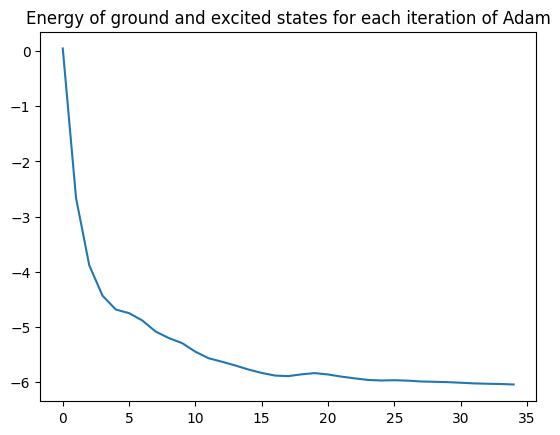

In [38]:
energies = [combined[i][2] for i in range(len(combined))]

import matplotlib.pyplot as plt
plt.plot(list(range(len(combined))), energies)
plt.title("Energy of ground and excited states for each iteration of Adam")

In [39]:
print("The ground state energy of H2 is ", expectation_circ(qcs[0], best, observable))

The ground state energy of H2 is  -1.1299828629920967


In [40]:
print("The excited state energy of H2 is ", expectation_circ(qcs[1], best, observable))

The excited state energy of H2 is  -0.5108161539655733


### Conclusion:
<hr>

In this notebook we have shown the following:
<ol>
    <li>How to calculate the gradients of a circuit parameters in 3 different quantum programming langauges</li>
    <li>How to implement SSVQE in 3 different quantum programming languages</li>
    <li>We can get approximately the same results in the 3 languages</li>
</ol>

### References
<hr>

<ol>
    <li>QLM VQE tutorial: <a href="https://notebooks.gesis.org/binder/jupyter/user/myqlm-myqlm-notebooks-fywdbybe/notebooks/tutorials/variational_algorithms/vqe_getting_started_random_spin.ipynb">link</a></li>
    <li>Pennylane VQE tutorial and H2 hamiltonian: <a href="https://pennylane.ai/qml/demos/tutorial_vqe">link</a></li>
    <li>Qiskit Operators: <a href="https://qiskit-org-web-resources.s3.us.cloud-object-storage.appdomain.cloud/documentation/stable/0.19/tutorials/circuits_advanced/2_operators_overview.html">link</a></li>
    <li>Qiskit VQE: <a href="https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html">link</a></li>
    <li>Cirq terminal measurements: <a href="https://quantumai.google/reference/python/cirq/drop_terminal_measurements">link</a></li>
    <li>Pennylane parameter shift: <a href="https://pennylane.ai/qml/glossary/parameter_shift">link</a></li>
    <li>Python adam optimizer from scratch: <a href="https://www.geeksforgeeks.org/how-to-implement-adam-gradient-descent-from-scratch-using-python/">link</a></li>    
</ol>